In [67]:
from collections import defaultdict
from pathlib import Path
from pprint import pprint

import numpy as np
import yaml
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon
from itertools import product
import pandas as pd

PRED_PATH = Path().resolve() / "ax_runs" / "prediction"
STFS_PATH = Path().resolve() / "ax_runs" / "st_selection"
PLOT_PATH = Path().resolve() / "plots"

##### Plot 1: Regression performance

In [241]:
skip_methods = [
    # "jp_cb_stop",
    # "jp_const_gb_part_l1",
    # ones that take a long time to train
    # "jp_const_linforest_l1",
    # "jp_const_linforest_l2",
    # "jp_const_linforest_l2L2",
    # "jp_const_linforest_inf",
    # "jp_linear_linforest_l1",
    # "jp_linear_linforest_l2",
    # "jp_linear_linforest_l2L2",
    # "jp_linear_linforest_inf",
    # "joplen_linear_vor_inf",
    "fastel",
    "nn",
    # We're not trying to propose these norms, so they just confuse matters
    # "jp_linear_rf_inf",  # this one does very well on classification
    # "jp_linear_gb_inf", # This one does not do well in either case
    "jp_linear_vor_inf",
    "jp_linear_linforest_inf",
    "jp_const_vor_l1",
    "jp_linear_vor_l1",
    "jp_const_linforest_l1",
    "jp_linear_linforest_l1",
    "jp_const_gb_l1",
    "jp_linear_gb_l1",
    "jp_const_rf_l1",
    "jp_linear_rf_l1",
    # Want to focus on our proposed leaf/norm combinations
    # "jp_linear_gb_nn",
    "jp_const_gb_l2L2",
    # Adding linforest distracts from the main point
    "jp_linear_linforest_l2L2",
    "jp_linear_linforest_l2",
    "jp_const_linforest_l2L2",
    "jp_const_linforest_l2",
]

In [242]:
# load regression results
reg_res = defaultdict(lambda: defaultdict(dict))

for task_type in PRED_PATH.iterdir():
    for method_dir in task_type.iterdir():
        if method_dir.is_dir():
            for dataset_dir in method_dir.iterdir():
                if dataset_dir.is_dir():
                    fp = dataset_dir / "metadata.yaml"

                    if not fp.exists() or method_dir.name in skip_methods:
                        continue

                    with open(fp, "r") as f:
                        reg_res[task_type.name][method_dir.name][dataset_dir.name] = (
                            yaml.safe_load(f)
                        )


reg_res = {k: dict(v) for k, v in reg_res.items()}

In [243]:
counts = {k: len(v) for k, v in reg_res["regr"].items()}

sorted(counts.items(), key=lambda x: x[1])

[('jp_linear_gb_nn', 91),
 ('ridge', 91),
 ('jp_const_rf_l2', 94),
 ('jp_const_vor_l2L2', 94),
 ('jp_linear_rf_l2L2', 94),
 ('jp_linear_vor_l2', 94),
 ('jp_const_gb_l2', 94),
 ('jp_linear_vor_l2L2', 94),
 ('jp_linear_gb_inf', 94),
 ('lf', 94),
 ('et', 94),
 ('jp_linear_rf_inf', 94),
 ('jp_linear_gb_l2L2', 94),
 ('jp_linear_gb_l2', 94),
 ('jp_linear_rf_l2', 94),
 ('jp_const_vor_l2', 94),
 ('rf_fr', 97),
 ('gb_fr', 97),
 ('rf', 97),
 ('xgboost', 98),
 ('cb', 98),
 ('gb', 98)]

In [244]:
# only keep datasets shared by all methods
shared_datasets = defaultdict(lambda: defaultdict(set))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        # if len(datasets) in [10, 69]:
        #     continue

        for contains_categorical in [True, False, "postprocessed"]:
            keys = [
                k
                for k, v in datasets.items()
                if v["contains_categorical"] == contains_categorical
            ]

            if not shared_datasets[task_type][contains_categorical]:
                shared_datasets[task_type][contains_categorical] = set(keys)
            else:
                shared_datasets[task_type][contains_categorical] &= set(keys)

new_reg_res = defaultdict(lambda: defaultdict(dict))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        for contains_categorical in [True, False, "postprocessed"]:
            new_reg_res[task_type][method].update(
                {
                    k: v
                    for k, v in datasets.items()
                    if k in shared_datasets[task_type][contains_categorical]
                }
            )

reg_res = {k: dict(v) for k, v in new_reg_res.items()}

In [245]:
def plot_strip(
    reg_res: dict,
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    only_classification: bool = False,
    only_continuous: bool = False,
):
    """
    Create a strip plot based on the list of y-values.
    """
    x_values = []
    y_labels = []

    def score(vv: dict, only_classification: bool):
        # print(vv)
        if only_classification:
            return vv["metadata"]["test"]["zo_loss"]
        else:
            return vv["test_score"] / vv["dummy_loss"]

    rescaled_res = {
        k: {
            kk: score(vv, only_classification)
            for kk, vv in v.items()
            if not (
                only_continuous
                and vv["contains_categorical"] in [True, "postprocessed"]
            )
        }
        for k, v in reg_res.items()
    }

    rescaled_res = {k: v for k, v in rescaled_res.items() if len(v) > 0}

    median_res = {k: np.median(list(v.values())) for k, v in rescaled_res.items()}

    sorted_dict = {
        k: rescaled_res[k] for k in sorted(median_res, key=median_res.get)[::-1]
    }

    for k, v in sorted_dict.items():
        x_values.append(v.values())
        y_labels.append(k)

    fig, ax = plt.subplots(figsize=(10, len(rescaled_res) * 1 / 3), **plot_kwargs)

    for x_idx, val in enumerate(x_values):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in val]
        ax.scatter(val, y_values, **scatter_kwargs)

    x_lim = (0, max(ax.get_xlim()[1], 1.2))
    x_lim = (0, min(x_lim[1], 1 if only_classification else 1.5))

    for x_idx, val in enumerate(x_values[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    # plot vertical line for median for each model
    medians = [np.median(list(val)) for val in x_values]
    for x_value, median in zip(range(len(x_values)), medians):
        ax.vlines(median, x_value - 1 / 2, x_value + 1 / 2, color="k")

    ax.set_xlim(x_lim)

    print({k: v for k, v in zip(y_labels, medians)})

    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)

    if not only_classification:
        ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")

    ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

    plt.xlabel("Normalized Loss" if not only_classification else "Zero-One Loss")

    plt.tight_layout()

    return ax, medians, len(list(rescaled_res.values())[0])


def compare_methods(reg_res1, reg_res2, is_classification):
    method1, method2 = [], []

    for k, v in reg_res1.items():
        if k in reg_res2:
            v2 = reg_res2[k]

            if is_classification:
                method1.append(v["metadata"]["test"]["zo_loss"])
                method2.append(v2["metadata"]["test"]["zo_loss"])
            else:
                method1.append(v["test_score"] / v["dummy_loss"])
                method2.append(v2["test_score"] / v2["dummy_loss"])

    return wilcoxon(method1, method2, alternative="less", method="exact").pvalue

Only class: True, Only cont: False
{'et': 0.21825396825396826, 'jp_const_vor_l2L2': 0.19999999999999996, 'jp_linear_gb_inf': 0.19006901840490797, 'jp_const_vor_l2': 0.1879528985507246, 'jp_const': 0.17028985507246375, 'rf': 0.169047619047619, 'gb_fr': 0.169047619047619, 'jp_linear_vor_l2L2': 0.169047619047619, 'jp_linear_vor_l2': 0.169047619047619, 'gb': 0.16666666666666663, 'jp_linear_gb_l2L2': 0.16666666666666663, 'cb': 0.16666666666666663, 'lf': 0.16666666666666663, 'rf_fr': 0.16666666666666663, 'jp_linear_rf_l2L2': 0.16666666666666663, 'xgboost': 0.16666666666666663, 'jp_linear_rf_l2': 0.1644144144144144, 'jp_const_rf_l2': 0.15579710144927533, 'jp_linear_gb_l2': 0.15142857142857147, 'jp_linear_rf_inf': 0.1380952380952381}


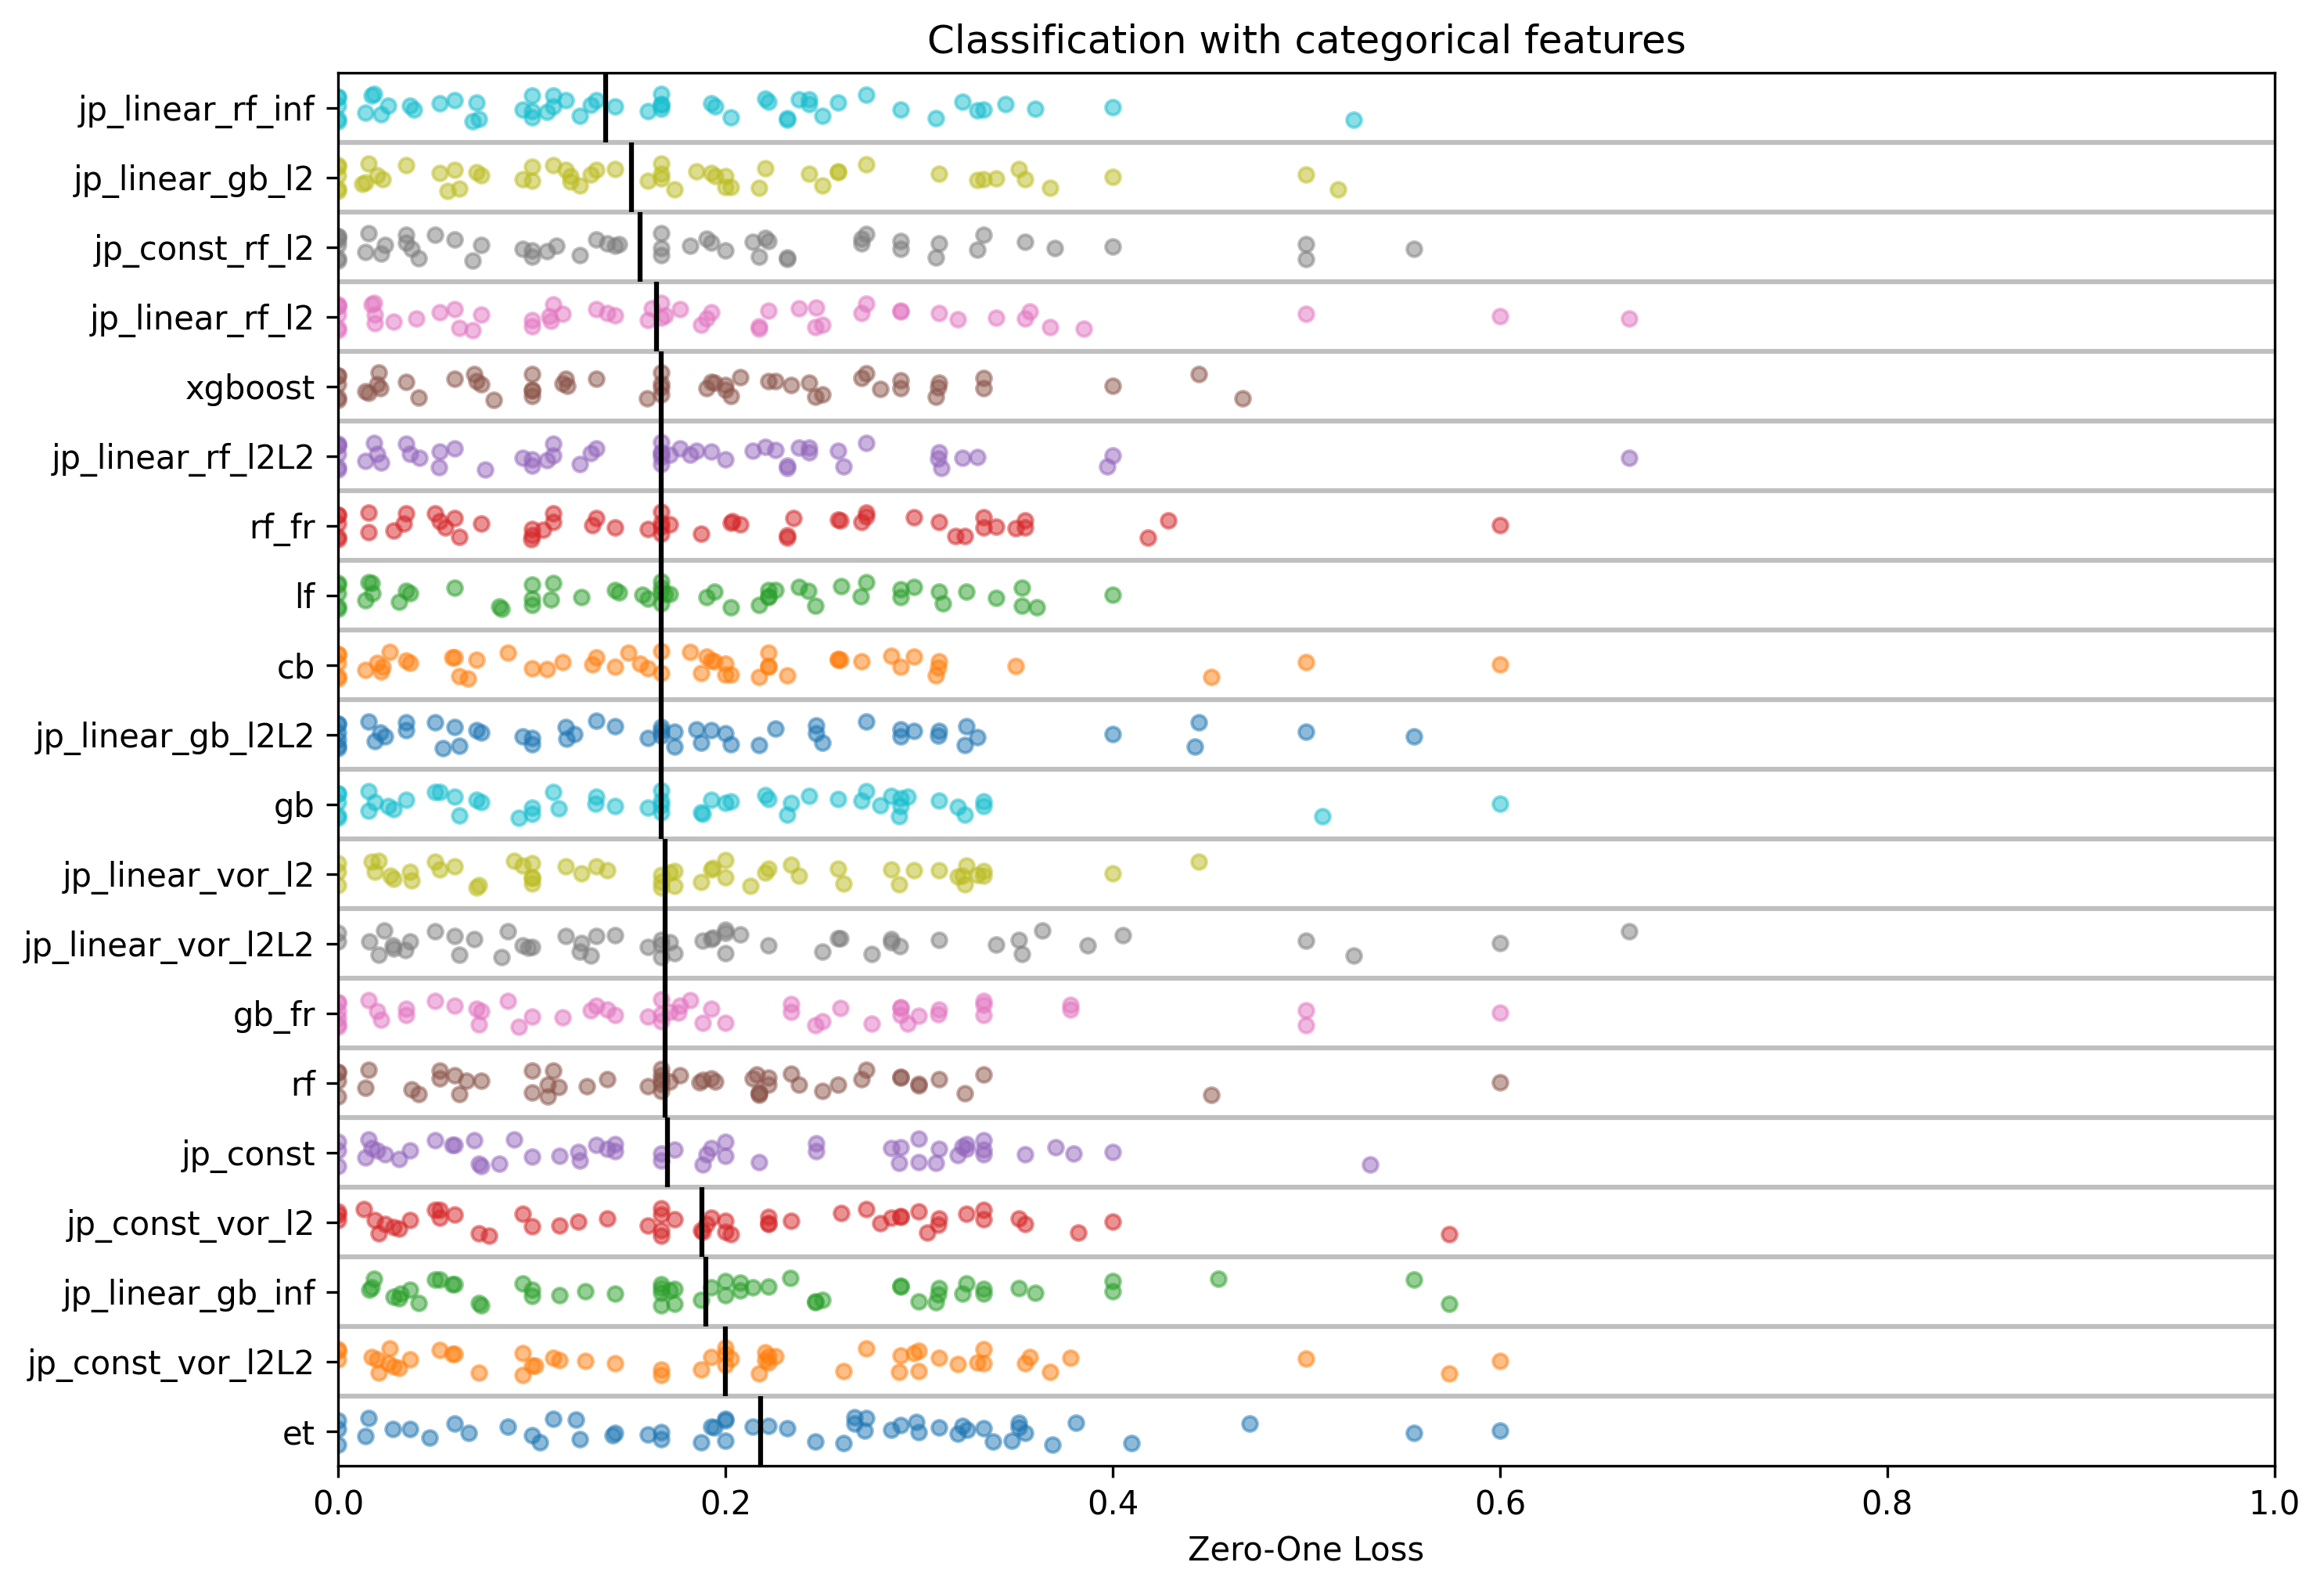

There ar 56 datasets
Only class: False, Only cont: False


/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


{'et': 0.8416633059404486, 'ridge': 0.7931543682169819, 'jp_const_vor_l2': 0.6847510548881535, 'jp_const_vor_l2L2': 0.6826312899890671, 'jp_linear_gb_inf': 0.6673291104416956, 'jp_linear_vor_l2L2': 0.6337142339518135, 'jp_linear_vor_l2': 0.6112895656060898, 'rf': 0.4647077307751822, 'rf_fr': 0.4500159541986216, 'lf': 0.40513745047388866, 'jp_linear_rf_inf': 0.3804082930922729, 'jp_linear_rf_l2L2': 0.3789288833862309, 'jp_linear_rf_l2': 0.3780183728725181, 'jp_const_rf_l2': 0.37702501506646235, 'xgboost': 0.36879770704422704, 'gb_fr': 0.3667450910344959, 'gb': 0.35625851657068486, 'cb': 0.31953029041745434, 'jp_linear_gb_nn': 0.3174914601935465, 'jp_const_gb_l2': 0.31748202610154636, 'jp_linear_gb_l2': 0.3107970746447165, 'jp_linear_gb_l2L2': 0.2965501320067945}


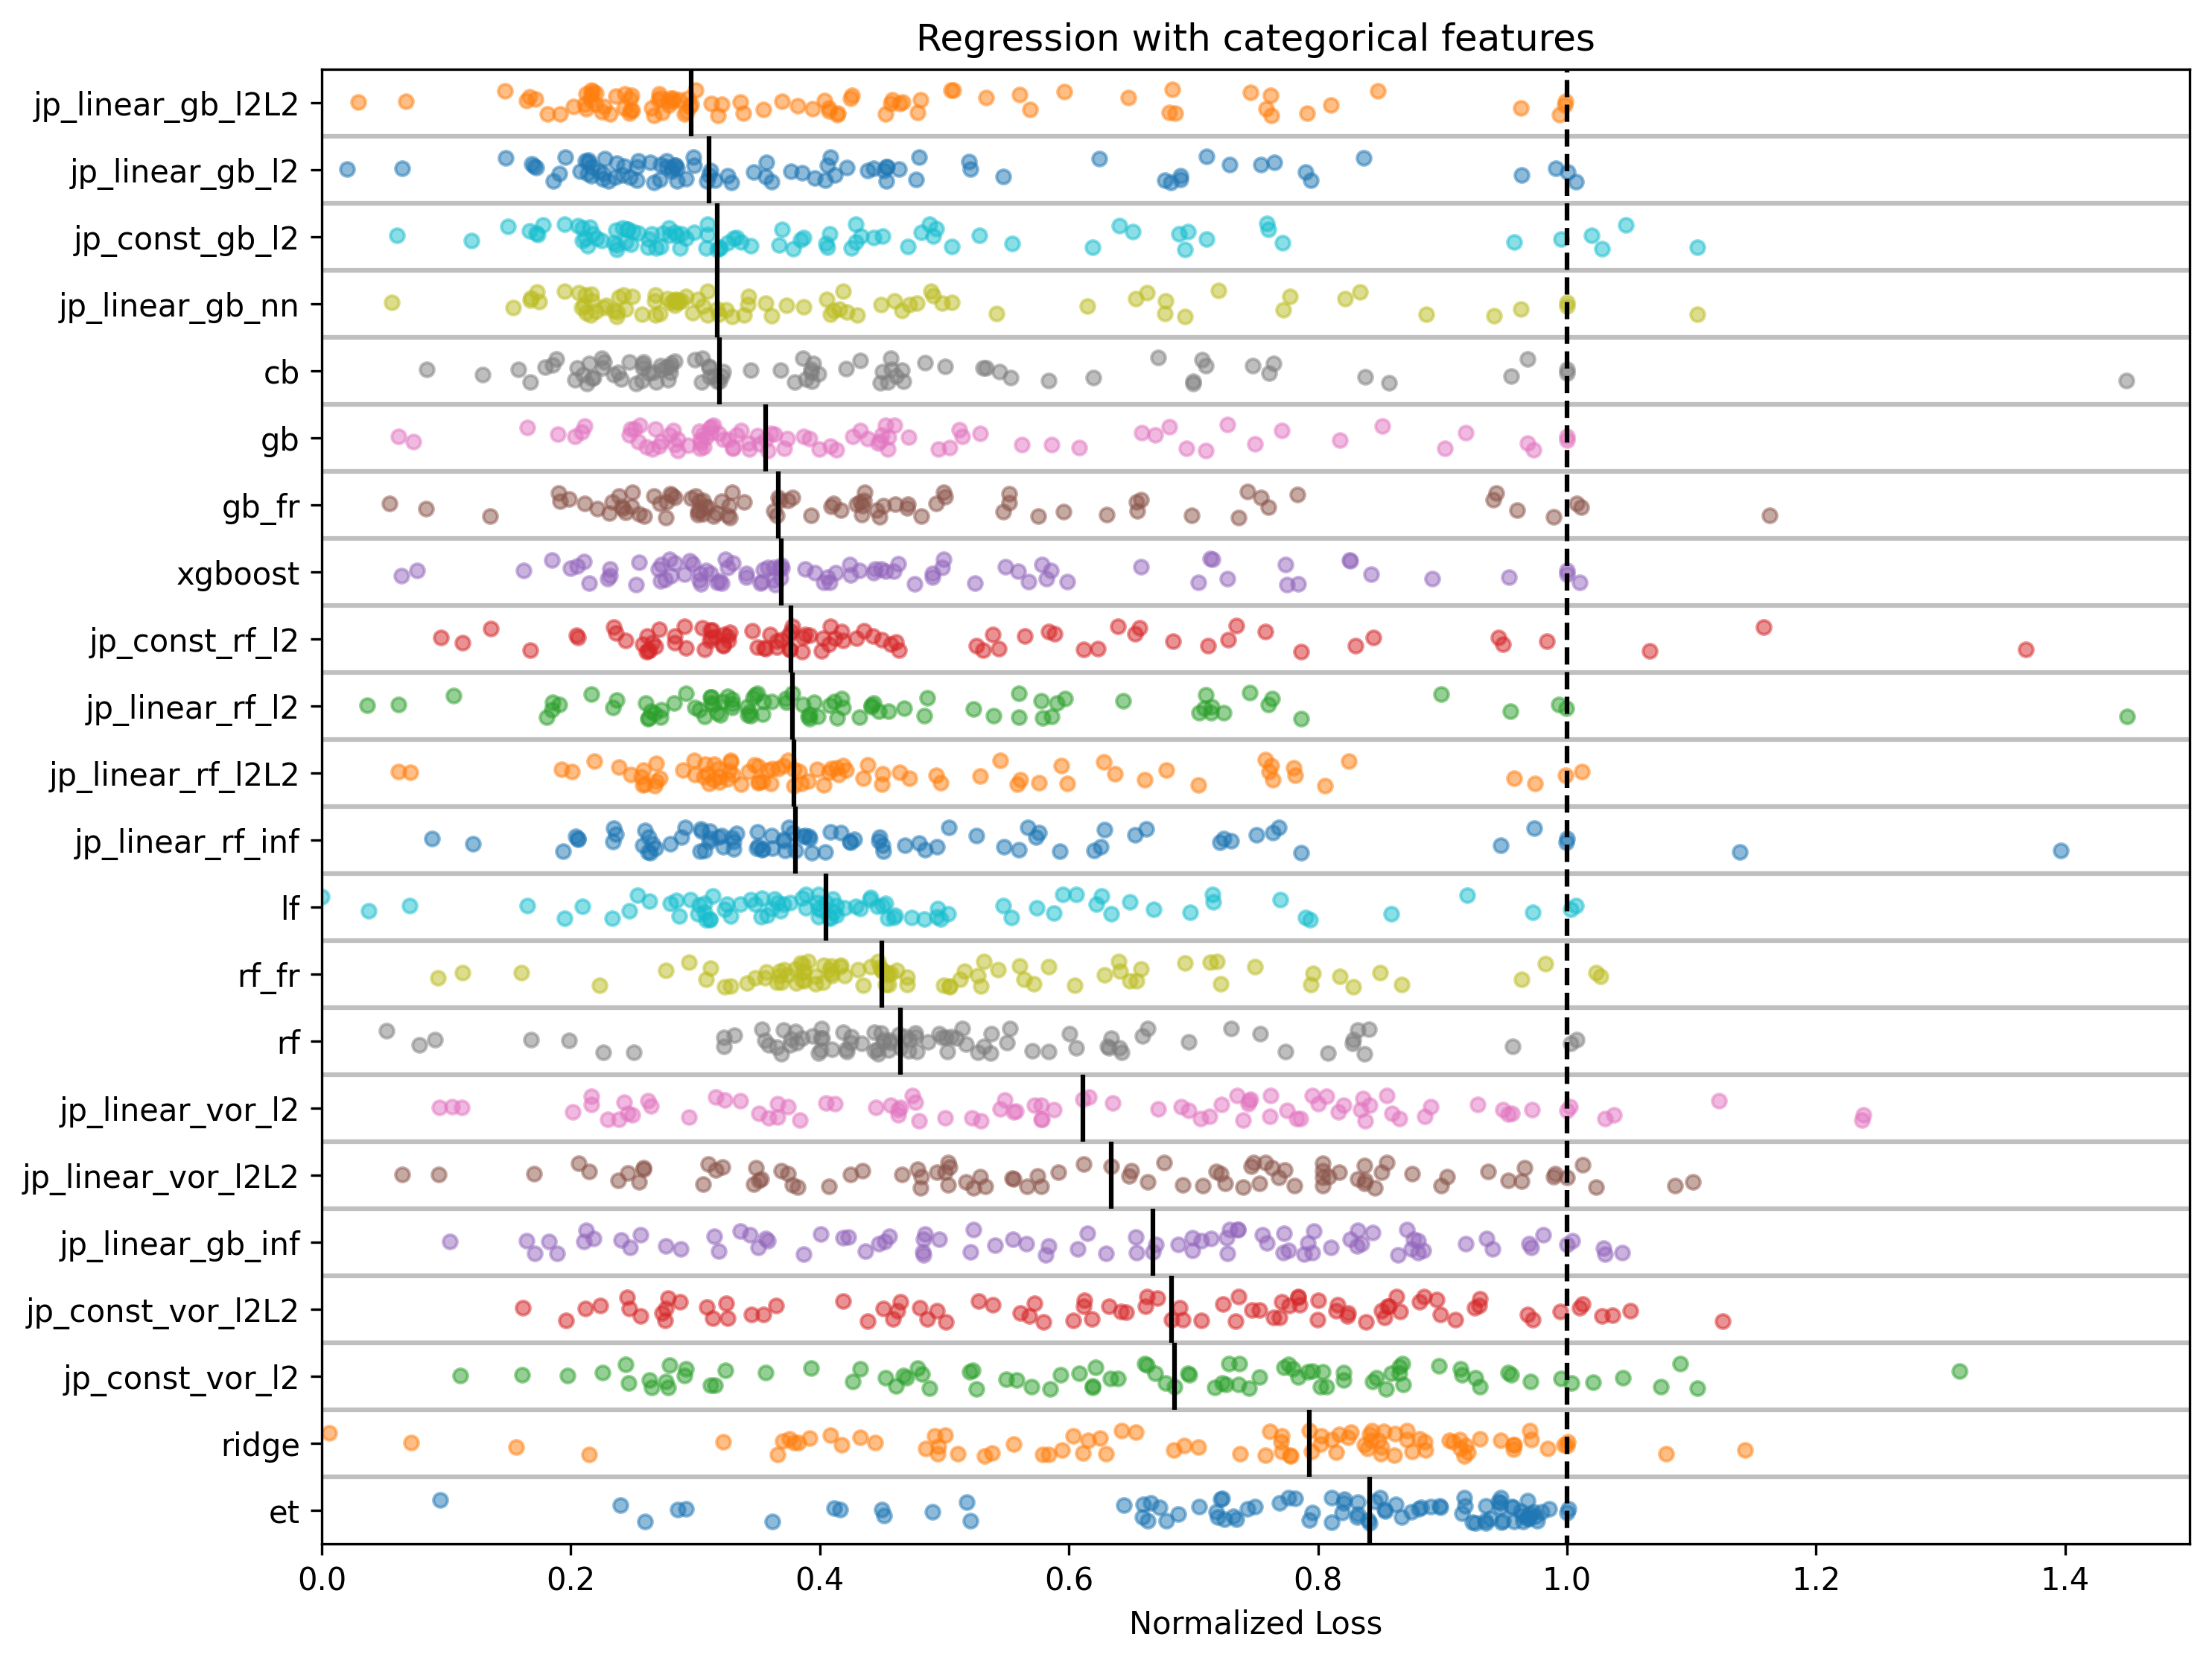

There ar 91 datasets


In [246]:
p_vals = defaultdict(lambda: defaultdict(dict))
n_datasets = defaultdict(lambda: defaultdict(int))

for only_class, only_cont in product([True, False], [False]):
    pred_type = "class" if only_class else "regr"

    print(f"Only class: {only_class}, Only cont: {only_cont}")

    if pred_type not in reg_res:
        continue

    ax, means, n_datasets[only_cont][pred_type] = plot_strip(
        reg_res[pred_type],
        scatter_kwargs={"alpha": 0.5, "s": 20},
        only_classification=only_class,
        only_continuous=only_cont,
        plot_kwargs={"dpi": 300},
    )

    title = "Classification" if only_class else "Regression"
    title += (
        " with only continuous features" if only_cont else " with categorical features"
    )

    ax.set_title(title)

    # plt.savefig(PLOT_PATH / "reg_strip.png", dpi=300)

    plt.show()

    print(f"There ar {n_datasets[only_cont][pred_type]} datasets")

    for method1, method2 in product(methods, repeat=2):
        if (
            method1 == method2
            or method1 not in reg_res[pred_type]
            or method2 not in reg_res[pred_type]
        ):
            continue

        valid_ds = [
            k
            for k, v in reg_res[pred_type][method1].items()
            if not (v["contains_categorical"] in [True, "postprocessed"] and only_cont)
        ]

        tmp = compare_methods(
            {k: v for k, v in reg_res[pred_type][method1].items() if k in valid_ds},
            {k: v for k, v in reg_res[pred_type][method2].items() if k in valid_ds},
            only_class,
        )

        p_vals[only_cont][pred_type][(method1, method2)] = tmp

p_vals = dict(p_vals)

In [247]:
p_vals[False]["regr"][("jp_linear_gb_l2L2", "jp_linear_gb_l2")]

0.6495427210108886

In [248]:
p_vals[False]["class"][("jp_linear_rf_l2L2", "jp_const_rf_l2")]

0.2478817587735545

##### Multitask sparsity pattern

In [249]:
def plot_joplen_weights(core_weights, task_weights, axs=None):
    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    if axs is None:
        fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    # axs[0].set_title("Common weights")
    axs[1].matshow(task_weights, **params)
    # axs[1].set_title("Task-specific weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_ylabel("Features")

    axs[1].set_xlabel("Tasks, partitions, and cells")

    plt.tight_layout()

    return ax

In [250]:
import pandas as pd

OUT_PATH = Path() / "experiments" / "manual" / "multitask"


# load data
def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    return (
        jp_res,
        dl_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
    )

In [251]:
(
    sarcos_jp_res,
    sarcos_dl_res,
    sarcos_dummy_results,
    sarcos_linear_results,
    sarcos_gb_results,
    sarcos_jp_core,
    sarcos_jp_task,
    sarcos_dl_core,
    sarcos_dl_task,
) = load_results("sarcos")

(
    nano_jp_res,
    nano_dl_res,
    nano_dummy_results,
    nano_linear_results,
    nano_gb_results,
    nano_jp_core,
    nano_jp_task,
    nano_dl_core,
    nano_dl_task,
) = load_results("nanoparticle")

In [252]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(core_weights, task_weights, exclude_bias, axs=None):
    if exclude_bias:
        core_weights = core_weights[:, :-1]
        task_weights = task_weights[:, :-1]

    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    # make the background white
    core_weights[core_weights == 0] = np.nan
    task_weights[task_weights == 0] = np.nan

    if axs is None:
        fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharey=True, sharex=True)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    # axs[0].set_title("Common weights")
    axs[1].matshow(task_weights, **params)
    # axs[1].set_title("Task-specific weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    # axs[1].set_xticks(np.arange(n_tasks) * n_cells + n_cells / 2)
    # axs[1].set_xticklabels([f"Task {i + 1}" for i in range(n_tasks)])

    axs2 = axs[0].twiny()
    axs2.spines["bottom"].set_position(("axes", 1.1))
    axs2.tick_params("both", length=0, width=0, which="minor")
    axs2.tick_params("both", direction="in", which="major")
    axs2.xaxis.set_ticks_position("bottom")
    axs2.tick_params(direction="out", axis="x")
    ticks = np.arange(n_tasks + 1) * n_cells
    axs2.set_xticks(ticks)
    axs2.set_xticklabels([])
    halfway_points = (ticks[1:] + ticks[:-1]) / 2
    axs2.xaxis.set_minor_locator(plt.FixedLocator(halfway_points))
    axs2.xaxis.set_minor_formatter(
        plt.FuncFormatter(lambda x, _: f"Task {int(x / n_cells + 1)}")
    )
    axs2.tick_params(axis="x", which="minor", pad=-15)  # Increase pad for more offse

    for ax in axs:
        ax.set_xticks([])

    # for ax in axs:
    #     ax.set_ylabel("Features")
    axs[0].set_ylabel("Common ($\\mathbf{B}$)")
    axs[1].set_ylabel("Task-specific ($\\mathbf{A}$)")

    axs[1].set_xlabel("Index of weights")

    plt.tight_layout()

    return ax

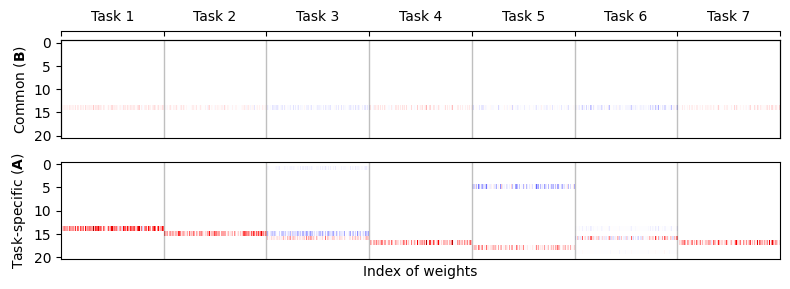

In [253]:
ax = plot_joplen_weights(sarcos_jp_core, sarcos_jp_task, exclude_bias=True)

plt.savefig("plots/fig4.pdf", bbox_inches="tight")

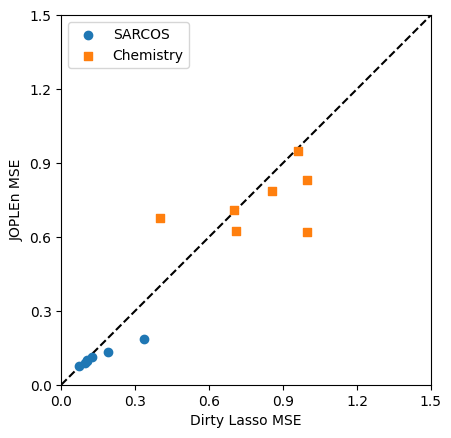

In [254]:
plt.scatter(
    sarcos_dl_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    label="SARCOS",
    marker="o",
    zorder=10,
)

plt.scatter(
    nano_dl_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    label="Chemistry",
    marker="s",
    zorder=10,
)

x = np.linspace(0, 1.5, 6, endpoint=True)

plt.plot(x, x, color="k", linestyle="--", zorder=0)

plt.xticks(x)
plt.yticks(x)

plt.xlabel("Dirty Lasso MSE")
plt.ylabel("JOPLEn MSE")
plt.legend()
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

plt.gca().set_aspect("equal")

plt.show()

### Investigate N-norm vs F-norm penalty

In [317]:
l2_losses = reg_res["regr"]["jp_linear_gb_l2"]
n_losses = reg_res["regr"]["jp_linear_gb_nn"]

where_l2_better = []
where_nn_better = []

for k, v in l2_losses.items():
    norm_l2_score = v["test_score"] / v["dummy_loss"]
    norm_nn_score = n_losses[k]["test_score"] / n_losses[k]["dummy_loss"]
    ratio = norm_l2_score / norm_nn_score

    if ratio > 1 + 1e-1 and norm_nn_score < 1:
        where_nn_better.append((k, norm_l2_score / norm_nn_score))
    elif ratio < 1 - 1e-1 and norm_l2_score < 1:
        where_l2_better.append((k, norm_l2_score / norm_nn_score))

print(f"Where L2 is better: {len(where_l2_better)}")
print(f"Where NN is better: {len(where_nn_better)}")

Where L2 is better: 14
Where NN is better: 10


In [318]:
sorted(where_l2_better, key=lambda x: x[1])

[('561_cpu', 0.05742794432367193),
 ('651_fri_c0_100_25', 0.6702472381114262),
 ('230_machine_cpu', 0.6802107006286534),
 ('687_sleuth_ex1605', 0.7187316742449038),
 ('659_sleuth_ex1714', 0.7636881663421498),
 ('612_fri_c1_1000_5', 0.8552835614376728),
 ('641_fri_c1_500_10', 0.8576026814528411),
 ('609_fri_c0_1000_5', 0.8599118582091292),
 ('210_cloud', 0.8606802695990513),
 ('621_fri_c0_100_10', 0.8680570508174275),
 ('579_fri_c0_250_5', 0.8769405145209306),
 ('666_rmftsa_ladata', 0.8813768707725164),
 ('1089_USCrime', 0.8871454039684246),
 ('665_sleuth_case2002', 0.8930691323327667)]

In [319]:
sorted(where_nn_better, key=lambda x: x[1])

[('597_fri_c2_500_5', 1.1022468622379908),
 ('586_fri_c3_1000_25', 1.1248260711732927),
 ('623_fri_c4_1000_10', 1.1258475741829521),
 ('657_fri_c2_250_10', 1.1319460654115236),
 ('505_tecator', 1.14485492738587),
 ('663_rabe_266', 1.1535101920617374),
 ('591_fri_c1_100_10', 1.1750546477442403),
 ('560_bodyfat', 1.2417368137226839),
 ('678_visualizing_environmental', 1.2849647099819246),
 ('207_autoPrice', 1.4837091149057484)]

In [325]:
def score_ds(str_ds, str_method):
    tmp = reg_res["regr"][str_method][str_ds]
    return tmp["test_score"] / tmp["dummy_loss"]


def compare_three(
    str_ds,
):
    print(str_ds)
    for method in ["jp_linear_gb_l2", "jp_linear_gb_nn", "jp_linear_gb_inf"]:
        padded_method = method.ljust(20)
        print(f"{padded_method} {score_ds(str_ds, method): 4f}")

In [326]:
# Here, nn norm is better than inf because it doesn't force sparsity
# Barely any sparsity
# https://epistasislab.github.io/pmlb/profile/665_sleuth_case2002.html
compare_three("665_sleuth_case2002")

665_sleuth_case2002
jp_linear_gb_l2       0.689305
jp_linear_gb_nn       0.771838
jp_linear_gb_inf      0.875177


In [323]:
# Here the inf norm is better because it forces sparsity
# High degree of redundancy
# https://epistasislab.github.io/pmlb/profile/207_autoPrice.html
compare_three("207_autoPrice")

207_autoPrice
jp_linear_gb_l2       0.421894
jp_linear_gb_nn       0.284351
jp_linear_gb_inf      0.240576


In [324]:
# Here the NN is the best. Probably because of weak correlation between features
# https://epistasislab.github.io/pmlb/profile/678_visualizing_environmental.html
compare_three("678_visualizing_environmental")

678_visualizing_environmental
jp_linear_gb_l2       0.790094
jp_linear_gb_nn       0.614876
jp_linear_gb_inf      0.687705


In [357]:
from pmlb import fetch_data

ds_name = "678_visualizing_environmental"
df = fetch_data(
    ds_name,
    local_cache_dir=Path("..") / "datasets" / "pmlb" / "raw" / "reg",
)

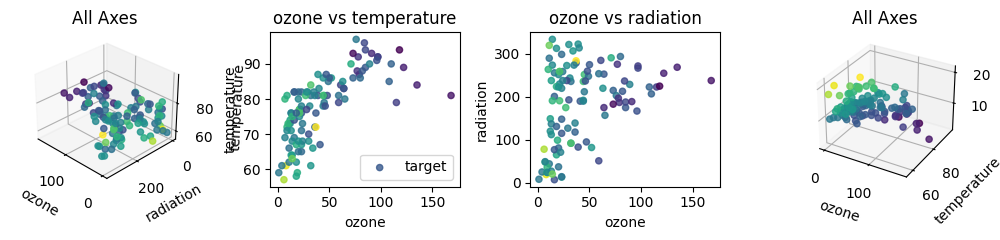

In [399]:
import matplotlib.pyplot as plt

# Define different camera orientations
# Create figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))

axis_labels = ["ozone", "radiation", "temperature"]

shared_params = {"s": 20, "cmap": "viridis", "alpha":0.8}

# Plot 2D scatter plots
axs[1].scatter(
    df[axis_labels[0]], df[axis_labels[2]], c=df["target"], **shared_params, label="target",
)
axs[1].set_xlabel(axis_labels[0])
axs[1].set_ylabel(axis_labels[2])
axs[1].set_title(f"{axis_labels[0]} vs {axis_labels[2]}")
axs[1].legend()

axs[2].scatter(df[axis_labels[0]], df[axis_labels[1]], c=df["target"], **shared_params)
axs[2].set_xlabel(axis_labels[0])
axs[2].set_ylabel(axis_labels[1])
axs[2].set_title(f"{axis_labels[0]} vs {axis_labels[1]}")

# Plot 3D scatter plot
axs[0].axis("off")
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.scatter(
    df[axis_labels[0]],
    df[axis_labels[1]],
    df[axis_labels[2]],
    c=df["target"],
    **shared_params,
)
ax.set_xlabel(axis_labels[0])
ax.set_ylabel(axis_labels[1])
ax.set_zlabel(axis_labels[2])
ax.set_title(f"All Axes")  # Add subplot title

# Set camera orientation for the 3D plot
ax.view_init(elev=30, azim=135)

axs[3].axis("off")
ax = fig.add_subplot(1,4,4, projection="3d")
ax.scatter(
    df[axis_labels[0]],
    df[axis_labels[2]],
    df["target"],
    c=df["target"],
    **shared_params,
)
ax.set_xlabel(axis_labels[0])
ax.set_ylabel(axis_labels[2])
ax.set_zlabel("target")
ax.set_title(f"All Axes")  # Add subplot title

plt.tight_layout()
plt.show()

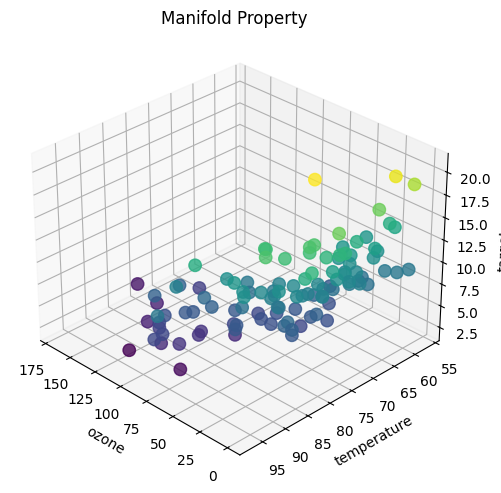

In [405]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(projection="3d")
ax.scatter(
    df[axis_labels[0]],
    df[axis_labels[2]],
    df["target"],
    c=df["target"],
    cmap="viridis",
    s=80,
    alpha=0.8,
)
ax.set_xlabel(axis_labels[0])
ax.set_ylabel(axis_labels[2])
ax.set_zlabel("target")
ax.set_title("Manifold Property")  # Add subplot title

ax.view_init(elev=30, azim=135)

plt.tight_layout()
plt.show()

NN seems to work well when we focus on datasets where the label is some function of a sparse feature space